#### Observation from Kaggle: Your score is the percentage of passengers you correctly predict. This is known as accuracy.

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

%matplotlib inline

#### Reading DataSets

In [2]:
df_init = pd.read_csv('train.csv')
df_init.head(40)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### No need for names and ticket numbers, right?

In [3]:
del df_init['Name']
del df_init['Ticket']
df_init.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


### This cabin variable, it looks like it has a lot of NaN, right? Let's check it

In [4]:
df_init['Cabin'].isna().sum()

687

In [5]:
len(df_init['Cabin'])

891

### Yeah, that looks like a lot. Let's get rid of it or it will hinder the results of our work

In [6]:
del df_init['Cabin']
df_init.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Let's combine the number of family members in one variable

In [7]:
df_init.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [8]:
df_init['Family'] = df_init['SibSp'] + df_init['Parch']
del(df_init['SibSp'])
del(df_init['Parch'])
df_init.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0


### Wait, what if there are  are more missing values? Let's check it

In [9]:
for ind in df_init.columns:
    print('Number of Missing', ind,':', df_init[ind].isna().sum())

Number of Missing PassengerId : 0
Number of Missing Survived : 0
Number of Missing Pclass : 0
Number of Missing Sex : 0
Number of Missing Age : 177
Number of Missing Fare : 0
Number of Missing Embarked : 2
Number of Missing Family : 0


### Woops, if only it were that easy. How many entries does our DataFrame have in total?

In [10]:
df_init.shape[0]

891

In [11]:
print(177/891)

0.19865319865319866


### So, about 20 percent of the age variable is missing. I think we should let go of it, but I am not sure. Let's do both ways and then compare results. But before, We are gonna input those missing 'Embarked' entries:

In [12]:
df_init['Embarked'].fillna(value = df_init['Embarked'].mode()[0], inplace = True)
for ind in df_init.columns:
    print('Number of Missing', ind,':', df_init[ind].isna().sum())

Number of Missing PassengerId : 0
Number of Missing Survived : 0
Number of Missing Pclass : 0
Number of Missing Sex : 0
Number of Missing Age : 177
Number of Missing Fare : 0
Number of Missing Embarked : 0
Number of Missing Family : 0


#### Looking good

# Deleting Age

In [13]:
del(df_init['Age'])
for ind in df_init.columns:
    print('Number of Missing', ind,':', df_init[ind].isna().sum())
df_init.head()

Number of Missing PassengerId : 0
Number of Missing Survived : 0
Number of Missing Pclass : 0
Number of Missing Sex : 0
Number of Missing Fare : 0
Number of Missing Embarked : 0
Number of Missing Family : 0


,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Family
0,1,0,3,male,7.2500,S,1
1,2,1,1,female,71.2833,C,1
2,3,1,3,female,7.9250,S,0
3,4,1,1,female,53.1000,S,1
4,5,0,3,male,8.0500,S,0


### Checking some distributions

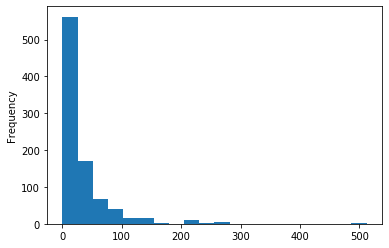

In [14]:
df_init['Fare'].plot(kind = 'hist', bins = 20)

#### I wonder how this would look like after some scaling.

In [15]:
# Some insurance is always nice, right? :D
bkp = pd.DataFrame()
bkp = df_init
bkp.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Family
0,1,0,3,male,7.2500,S,1
1,2,1,1,female,71.2833,C,1
2,3,1,3,female,7.9250,S,0
3,4,1,1,female,53.1000,S,1
4,5,0,3,male,8.0500,S,0


In [16]:
df_init = bkp
df_init.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Family
0,1,0,3,male,7.2500,S,1
1,2,1,1,female,71.2833,C,1
2,3,1,3,female,7.9250,S,0
3,4,1,1,female,53.1000,S,1
4,5,0,3,male,8.0500,S,0


In [17]:
df_init['Fare'] = ((df_init['Fare'] - df_init['Fare'].min())/(df_init['Fare'].max() - df_init['Fare'].min()))
df_init.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Family
0,1,0,3,male,0.014151,S,1
1,2,1,1,female,0.139136,C,1
2,3,1,3,female,0.015469,S,0
3,4,1,1,female,0.103644,S,1
4,5,0,3,male,0.015713,S,0


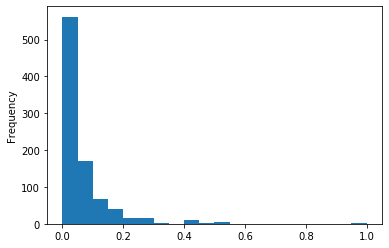

In [18]:
df_init['Fare'].plot(kind = 'hist', bins = 20)

### Does not change much, huh? Well, I think it is time to get some dummies.

In [19]:
df_init = pd.get_dummies(df_init)
df_init.head()

,PassengerId,Survived,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0.014151,1,0,1,0,0,1
1,2,1,1,0.139136,1,1,0,1,0,0
2,3,1,3,0.015469,0,1,0,0,0,1
3,4,1,1,0.103644,1,1,0,0,0,1
4,5,0,3,0.015713,0,0,1,0,0,1


# Stage is ready, the show is about to start

In [20]:
df_init.head()

,PassengerId,Survived,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0.014151,1,0,1,0,0,1
1,2,1,1,0.139136,1,1,0,1,0,0
2,3,1,3,0.015469,0,1,0,0,0,1
3,4,1,1,0.103644,1,1,0,0,0,1
4,5,0,3,0.015713,0,0,1,0,0,1


In [21]:
x_train = pd.DataFrame()
y_train = pd.DataFrame()
y_train = df_init['Survived']
x_train = df_init

In [22]:
x_train.head()

,PassengerId,Survived,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0.014151,1,0,1,0,0,1
1,2,1,1,0.139136,1,1,0,1,0,0
2,3,1,3,0.015469,0,1,0,0,0,1
3,4,1,1,0.103644,1,1,0,0,0,1
4,5,0,3,0.015713,0,0,1,0,0,1


In [23]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [24]:
del(x_train['PassengerId'])
del(x_train['Survived'])
x_train.head()

,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.014151,1,0,1,0,0,1
1,1,0.139136,1,1,0,1,0,0
2,3,0.015469,0,1,0,0,0,1
3,1,0.103644,1,1,0,0,0,1
4,3,0.015713,0,0,1,0,0,1


### Almost forgot to MaxMin the Family variable.

In [25]:
df_init['Family'] = ((df_init['Family'] - df_init['Family'].min())/(df_init['Family'].max() - df_init['Family'].min()))
df_init.head()

,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.014151,0.1,0,1,0,0,1
1,1,0.139136,0.1,1,0,1,0,0
2,3,0.015469,0.0,1,0,0,0,1
3,1,0.103644,0.1,1,0,0,0,1
4,3,0.015713,0.0,0,1,0,0,1


### Making the train-test split

In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size = 0.3)

# All right, here goes the first, least accurate prediction for this project. Let's see how it fares

In [27]:
X = pd.read_csv('test.csv')
y_first = pd.DataFrame()
y_first['PassengerId'] = X['PassengerId']
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [28]:
X['Family'] = X['SibSp'] + X['Parch']
X['Family'] = ((X['Family'] - X['Family'].min())/(X['Family'].max() - X['Family'].min()))
X['Fare'] = ((X['Fare'] - X['Fare'].min())/(X['Fare'].max() - X['Fare'].min()))

del(X['PassengerId'])
del(X['Name'])
del(X['Ticket'])
del(X['Cabin'])
del(X['SibSp'])
del(X['Parch'])
del(X['Age'])

X = pd.get_dummies(X)

X.head()

,Pclass,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.015282,0.0,0,1,0,1,0
1,3,0.013663,0.1,1,0,0,0,1
2,2,0.018909,0.0,0,1,0,1,0
3,3,0.016908,0.0,0,1,0,0,1
4,3,0.023984,0.2,1,0,0,0,1


In [29]:
for ind in X.columns:
    print('Number of Missing', ind,':', X[ind].isna().sum())

Number of Missing Pclass : 0
Number of Missing Fare : 1
Number of Missing Family : 0
Number of Missing Sex_female : 0
Number of Missing Sex_male : 0
Number of Missing Embarked_C : 0
Number of Missing Embarked_Q : 0
Number of Missing Embarked_S : 0


In [30]:
X['Fare'].fillna(value = np.average(X['Fare'].dropna()), inplace = True)
for ind in X.columns:
    print('Number of Missing', ind,':', X[ind].isna().sum())

Number of Missing Pclass : 0
Number of Missing Fare : 0
Number of Missing Family : 0
Number of Missing Sex_female : 0
Number of Missing Sex_male : 0
Number of Missing Embarked_C : 0
Number of Missing Embarked_Q : 0
Number of Missing Embarked_S : 0


In [31]:
clf = RandomForestClassifier(max_depth = 4, random_state = 0)
clf.fit(x_train, y_train)
ys = clf.predict(X)

In [32]:
y_first['Survived'] = ys
y_first.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [33]:
y_first.to_csv('submission.csv', index = False)

In [34]:
def submit (ysub):
    sub = pd.DataFrame()
    sub['PassengerId'] = y_first['PassengerId']
    sub['Survived'] = ysub
    sub.to_csv('submission.csv', index = False)
    return

# Baseline results:

![baseline](baseline.png)

# Objective: Get that number up to 85%

# Baseline established, now the real fun begins

### Ok, let's assemble our metrics platform

In [35]:
def accuracy (yy, nn):
    acc = accuracy_score(ytest, yy)
    print('The accuracy of the model', nn, 'is: ', acc)
    return

### But will it blend?

In [36]:
clf = RandomForestClassifier(max_depth = 5, random_state = 0)
clf.fit(xtrain, ytrain)
ys = clf.predict(xtest)
accuracy(ys, 'Random Forest Classifier')

The accuracy of the model Random Forest Classifier is:  0.7611940298507462


### Yay, it works!

### I used the Random Forest Classifier because it is the first I have ever learned about, but there are a lot of classifiers out there. I wonder how they would fare against this dataset. Well, let's find out!

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def model_testing(xtrain, ytrain, xtest):
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QDA", 'ExtraTrees', 'GradiantBoostingClassifier', 'SVC']

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel = "linear", C = 0.025),
        SVC(gamma = 2, C = 1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth = 5),
        RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1),
        MLPClassifier(alpha = 1, max_iter = 1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier(),
        SVC()]

    for name, clf in zip(names, classifiers):
            clf.fit(xtrain, ytrain)
            ys = clf.predict(xtest)
            accuracy(ys, name)

In [38]:
model_testing(xtrain, ytrain, xtest)

The accuracy of the model Nearest Neighbors is:  0.746268656716418
The accuracy of the model Linear SVM is:  0.7574626865671642
The accuracy of the model RBF SVM is:  0.7835820895522388
The accuracy of the model Gaussian Process is:  0.7835820895522388
The accuracy of the model Decision Tree is:  0.75
The accuracy of the model Random Forest is:  0.7873134328358209
The accuracy of the model Neural Net is:  0.7798507462686567
The accuracy of the model AdaBoost is:  0.7649253731343284
The accuracy of the model Naive Bayes is:  0.7649253731343284
The accuracy of the model QDA is:  0.6082089552238806
The accuracy of the model ExtraTrees is:  0.75
The accuracy of the model GradiantBoostingClassifier is:  0.7611940298507462
The accuracy of the model SVC is:  0.7611940298507462


## Looks like the first time is the charm! Well, at least for now. Later we are gonna use some model stacking and these results will be very useful!  
## Our next step shall be the cross-validation and the hyperparameter tuning

In [39]:
# Preparing the lists for the hyperparameter tuning
estimators = [5, 7, 10, 15]
crit = ['gini', 'entropy']
mdepth = [4, 5, 6]
mssplit = [2, 5, 10]
mfeatures = ['auto', 'sqrt', 'log2'] # can be int, float or None
# Preparing the dictionary 
parameters = {'n_estimators': estimators, 'criterion': crit, 'min_samples_split': mssplit, 'max_features': mfeatures, 'max_depth':mdepth}

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
clf = RandomForestClassifier()
score = make_scorer(accuracy_score, greater_is_better = True)
gsc = GridSearchCV(estimator = clf, cv = skf, param_grid = parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(xtrain, ytrain)
gsc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_estimators': 5}

In [40]:
ys = gsc.best_estimator_.predict(xtest)
accuracy(ys, 'Random Forest Classifier with hyperparameter tuning and cross-validation')

The accuracy of the model Random Forest Classifier with hyperparameter tuning and cross-validation is:  0.7686567164179104


In [41]:
gsc.fit(x_train, y_train)
ys = gsc.best_estimator_.predict(X)
submit(ys)
gsc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 5}

![improvement1](improvement1.png)

## Nice! There was some improvement in the results!

# Well, I guess we are not gonna go much further by fiddling with GridSearch alone. Let's take a step back and re-examine the original data. Maybe we can squeeze some more feature engineering into the mix?

In [42]:
og_train = pd.read_csv('train.csv')
og_test = pd.read_csv('test.csv')
og_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
og_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [44]:
#Note to self: this is a much better way of identifying missing values
og_train.info()
print('_'*40)
og_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [45]:
og_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Thayer, Mr. John Borland",male,CA. 2343,G6,S
freq,1,577,7,4,644


### When a ship is sinking, everybody knows that women and children get saved first. Heck, this bit has been used to exaustion in comedy. Let's ask our data if this is the case.

In [46]:
og_train[["Sex", "Survived"]].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


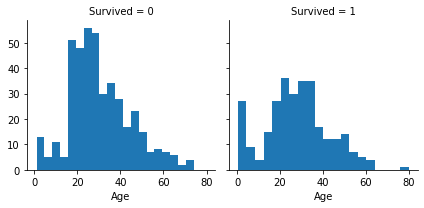

In [47]:
g = sns.FacetGrid(og_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Well, it is apparently true. According to our data, around 74% of the women survived, as opposed to 18,8% of the men. Additionally, we can see on the histogram that from the people that did not survive (Survived = 0), a minority were children, and from the people that did survive (Survived = 1), There is a larger number of children. I wonder how important the class was on the survival.

In [48]:
og_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Pretty important, it seems. What about the size of the family?

In [49]:
og_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [50]:
og_train[["Parch", "Survived"]].groupby(['Parch'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### It would seem that having a small family improved the chances of survival compared to people who were alone, but people who were alone would have a better chance of survival compared to people from bigger families, but we'll get back to that after.

### Apparently, ticket and cabin really have no place here. Let's get rid of those (again).

In [51]:
del(og_train['Ticket'])
del(og_train['Cabin'])
del(og_test['Ticket'])
del(og_test['Cabin'])
og_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [52]:
og_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


### One of the first assumptions that was made was that the variable 'Name' held no useful information, but it has been pointed out  by Manav Sehgal (his notebook is linked on the references section) that we can extract the titles from the names, and this data is potentially useful in this analysis.

In [53]:
combine = [og_train, og_test]
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

pd.crosstab(og_train['Title'], og_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [54]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
og_train[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### This means that we no longer need the 'Name' neither 'PassengerId'

In [55]:
og_train = og_train.drop(['Name', 'PassengerId'], axis=1)
og_test = og_test.drop(['Name'], axis=1)
combine = [og_train, og_test]

### Later, we will categorize this data using get_dummies. 

### In the notebook by Manav Sehgal, he used weighted guesses to fill the variable 'Age'. In this one, on the other hand we considered that such variable had too many missing values to be considered useful. As an experiment, let's compare both methods.

### Personally, I think imputing the age will yield a better result

In [56]:
og_train_dage = og_train #dage = deleting age
og_test_dage = og_test
combine_dage = [og_train_dage, og_test_dage]

## First, using Manav Sehgal's method.

### To accomplish that, we have to implement his encoding for the 'Sex' variable. I am gonna use his encoding in a copy of the dataframes, once I plan on encoding that variable using get_dummies further ahead.

In [57]:
og_train_copy = og_train
og_test_copy = og_test
combine_copy = [og_train_copy, og_test_copy]

In [58]:
for dataset in combine_copy:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

og_train_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,Mr
1,1,1,1,38.0,1,0,71.2833,C,Mrs
2,1,3,1,26.0,0,0,7.9250,S,Miss
3,1,1,1,35.0,1,0,53.1000,S,Mrs
4,0,3,0,35.0,0,0,8.0500,S,Mr


In [59]:
og_test_copy.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34.5,0,0,7.8292,Q,Mr
1,893,3,1,47.0,1,0,7.0000,S,Mrs
2,894,2,0,62.0,0,0,9.6875,Q,Mr
3,895,3,0,27.0,0,0,8.6625,S,Mr
4,896,3,1,22.0,1,1,12.2875,S,Mrs


In [60]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [61]:
for dataset in combine_copy:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age'].dropna()
            age_guess = guess_df.median()
            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int(age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

og_train_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,Mr
1,1,1,1,38,1,0,71.2833,C,Mrs
2,1,3,1,26,0,0,7.9250,S,Miss
3,1,1,1,35,1,0,53.1000,S,Mrs
4,0,3,0,35,0,0,8.0500,S,Mr


In [62]:
og_train_copy['AgeBand'] = pd.cut(og_train_copy['Age'], 5)
og_train_copy[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index = False).mean().sort_values(by = 'AgeBand', ascending = True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [63]:
og_train_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,22,1,0,7.2500,S,Mr,"(16.0, 32.0]"
1,1,1,1,38,1,0,71.2833,C,Mrs,"(32.0, 48.0]"
2,1,3,1,26,0,0,7.9250,S,Miss,"(16.0, 32.0]"
3,1,1,1,35,1,0,53.1000,S,Mrs,"(32.0, 48.0]"
4,0,3,0,35,0,0,8.0500,S,Mr,"(32.0, 48.0]"


In [64]:
og_test_copy['AgeBand'] = pd.cut(og_test_copy['Age'], 5)
og_test_copy.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,892,3,0,34,0,0,7.8292,Q,Mr,"(30.4, 45.6]"
1,893,3,1,47,1,0,7.0000,S,Mrs,"(45.6, 60.8]"
2,894,2,0,62,0,0,9.6875,Q,Mr,"(60.8, 76.0]"
3,895,3,0,27,0,0,8.6625,S,Mr,"(15.2, 30.4]"
4,896,3,1,22,1,1,12.2875,S,Mrs,"(15.2, 30.4]"


In [65]:
og_train['AgeBand'] = og_train_copy['AgeBand']
del(og_train['Age']) # We no longer need this
og_train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,0,7.2500,S,Mr,"(16.0, 32.0]"
1,1,1,1,1,0,71.2833,C,Mrs,"(32.0, 48.0]"
2,1,3,1,0,0,7.9250,S,Miss,"(16.0, 32.0]"
3,1,1,1,1,0,53.1000,S,Mrs,"(32.0, 48.0]"
4,0,3,0,0,0,8.0500,S,Mr,"(32.0, 48.0]"


In [66]:
og_test['AgeBand'] = og_test_copy['AgeBand']
del(og_test['Age']) # We no longer need this
og_test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,892,3,0,0,0,7.8292,Q,Mr,"(30.4, 45.6]"
1,893,3,1,1,0,7.0000,S,Mrs,"(45.6, 60.8]"
2,894,2,0,0,0,9.6875,Q,Mr,"(60.8, 76.0]"
3,895,3,0,0,0,8.6625,S,Mr,"(15.2, 30.4]"
4,896,3,1,1,1,12.2875,S,Mrs,"(15.2, 30.4]"


In [67]:
combine = [og_train, og_test]

### Creating a variable for family size

In [68]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

og_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [69]:
del(og_train['SibSp'])
del(og_train['Parch'])
del(og_test['SibSp'])
del(og_test['Parch'])
og_train.head()

,Survived,Pclass,Sex,Fare,Embarked,Title,AgeBand,FamilySize
0,0,3,0,7.2500,S,Mr,"(16.0, 32.0]",2
1,1,1,1,71.2833,C,Mrs,"(32.0, 48.0]",2
2,1,3,1,7.9250,S,Miss,"(16.0, 32.0]",1
3,1,1,1,53.1000,S,Mrs,"(32.0, 48.0]",2
4,0,3,0,8.0500,S,Mr,"(32.0, 48.0]",1


In [70]:
og_test.head()

,PassengerId,Pclass,Sex,Fare,Embarked,Title,AgeBand,FamilySize
0,892,3,0,7.8292,Q,Mr,"(30.4, 45.6]",1
1,893,3,1,7.0000,S,Mrs,"(45.6, 60.8]",2
2,894,2,0,9.6875,Q,Mr,"(60.8, 76.0]",1
3,895,3,0,8.6625,S,Mr,"(15.2, 30.4]",1
4,896,3,1,12.2875,S,Mrs,"(15.2, 30.4]",3


In [71]:
og_train['Embarked'].fillna(value = og_train['Embarked'].dropna().mode()[0], inplace = True)
og_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
Title         891 non-null object
AgeBand       891 non-null category
FamilySize    891 non-null int64
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 49.8+ KB


In [72]:
og_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null object
AgeBand        418 non-null category
FamilySize     418 non-null int64
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 23.4+ KB


### Ooops, let's patch that 'Fare' really quick

In [73]:
print(og_test['Fare'].dropna().mean())

35.6271884892086


In [74]:
og_test['Fare'].fillna(value = 35.6271884892086, inplace = True)
#og_test['Fare'] = float(og_test['Fare'])
og_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
AgeBand        418 non-null category
FamilySize     418 non-null int64
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 23.4+ KB


### There, fixed! :D

### Here, instead of binning the variable 'Fare', I am going to MaxMin it

In [75]:
og_train['Fare'] = ((og_train['Fare'] - og_train['Fare'].min())/(og_train['Fare'].max() - og_train['Fare'].min()))
og_test['Fare'] = ((og_test['Fare'] - og_test['Fare'].min())/(og_test['Fare'].max() - og_test['Fare'].min()))
og_train.head()

,Survived,Pclass,Sex,Fare,Embarked,Title,AgeBand,FamilySize
0,0,3,0,0.014151,S,Mr,"(16.0, 32.0]",2
1,1,1,1,0.139136,C,Mrs,"(32.0, 48.0]",2
2,1,3,1,0.015469,S,Miss,"(16.0, 32.0]",1
3,1,1,1,0.103644,S,Mrs,"(32.0, 48.0]",2
4,0,3,0,0.015713,S,Mr,"(32.0, 48.0]",1


In [76]:
og_test.head()

,PassengerId,Pclass,Sex,Fare,Embarked,Title,AgeBand,FamilySize
0,892,3,0,0.015282,Q,Mr,"(30.4, 45.6]",1
1,893,3,1,0.013663,S,Mrs,"(45.6, 60.8]",2
2,894,2,0,0.018909,Q,Mr,"(60.8, 76.0]",1
3,895,3,0,0.016908,S,Mr,"(15.2, 30.4]",1
4,896,3,1,0.023984,S,Mrs,"(15.2, 30.4]",3


### Getting those dummies and cleansing the data

In [77]:
og_train = pd.get_dummies(og_train)
y_og_train = pd.DataFrame()
y_og_train['Survived'] = og_train['Survived']
del(og_train['Survived'])
og_test = pd.get_dummies(og_test)
del(og_test['PassengerId'])
og_train.head()

,Pclass,Sex,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,"AgeBand_(-0.08, 16.0]","AgeBand_(16.0, 32.0]","AgeBand_(32.0, 48.0]","AgeBand_(48.0, 64.0]","AgeBand_(64.0, 80.0]"
0,3,0,0.014151,2,0,0,1,0,0,1,0,0,0,1,0,0,0
1,1,1,0.139136,2,1,0,0,0,0,0,1,0,0,0,1,0,0
2,3,1,0.015469,1,0,0,1,0,1,0,0,0,0,1,0,0,0
3,1,1,0.103644,2,0,0,1,0,0,0,1,0,0,0,1,0,0
4,3,0,0.015713,1,0,0,1,0,0,1,0,0,0,0,1,0,0


In [78]:
y_og_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [79]:
og_test.head()

,Pclass,Sex,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,"AgeBand_(-0.076, 15.2]","AgeBand_(15.2, 30.4]","AgeBand_(30.4, 45.6]","AgeBand_(45.6, 60.8]","AgeBand_(60.8, 76.0]"
0,3,0,0.015282,1,0,1,0,0,0,1,0,0,0,0,1,0,0
1,3,1,0.013663,2,0,0,1,0,0,0,1,0,0,0,0,1,0
2,2,0,0.018909,1,0,1,0,0,0,1,0,0,0,0,0,0,1
3,3,0,0.016908,1,0,0,1,0,0,1,0,0,0,1,0,0,0
4,3,1,0.023984,3,0,0,1,0,0,0,1,0,0,1,0,0,0


### Before proceeding, let's retest our models against the new data.

In [80]:
xtrain, xtest, ytrain, ytest = train_test_split(og_train, y_og_train, test_size = 0.3)
model_testing(xtrain, ytrain, xtest)

The accuracy of the model Nearest Neighbors is:  0.8097014925373134
The accuracy of the model Linear SVM is:  0.8059701492537313
The accuracy of the model RBF SVM is:  0.8134328358208955
The accuracy of the model Gaussian Process is:  0.8432835820895522
The accuracy of the model Decision Tree is:  0.8432835820895522
The accuracy of the model Random Forest is:  0.8470149253731343
The accuracy of the model Neural Net is:  0.832089552238806
The accuracy of the model AdaBoost is:  0.8432835820895522
The accuracy of the model Naive Bayes is:  0.3843283582089552
The accuracy of the model QDA is:  0.3619402985074627
The accuracy of the model ExtraTrees is:  0.8171641791044776
The accuracy of the model GradiantBoostingClassifier is:  0.8582089552238806
The accuracy of the model SVC is:  0.8544776119402985


### This is quite the change from our first result, isn't it?  
### By this analysis, the method we should go with wold be the Gaussian Process, which yielded the highest accuraccy. However, I think we would learn more if we stuck with Random Forest. After all, how else would we know if all that feature engineering was worth it?

In [81]:
# Preparing the lists for the hyperparameter tuning
estimators = [5, 7, 10, 15]
crit = ['gini', 'entropy']
mdepth = [4, 5, 6]
mssplit = [2, 5, 10]
mfeatures = ['auto', 'sqrt', 'log2'] # can be int, float or None

# Preparing the dictionary 
parameters = {'n_estimators': estimators, 'criterion': crit, 'min_samples_split': mssplit, 'max_features': mfeatures, 'max_depth':mdepth}

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
clf = RandomForestClassifier()
score = make_scorer(accuracy_score, greater_is_better = True)
gsc = GridSearchCV(estimator = clf, cv = skf, param_grid = parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(xtrain, ytrain)
gsc.best_params_
rf_best_parameters = gsc.best_params_

In [82]:
ys = gsc.best_estimator_.predict(xtest)
accuracy(ys, 'Random Forest Classifier with hyperparameter tuning, improved feature engineering and cross-validation')

The accuracy of the model Random Forest Classifier with hyperparameter tuning, improved feature engineering and cross-validation is:  0.835820895522388


### Well, 2% improvement is nothing to sneeze at, even in theory! Let's see how we perform in practice!

In [83]:
gsc.fit(og_train, y_og_train)
ys = gsc.best_estimator_.predict(og_test)
submit(ys)


![improvement2](improvement2.png)

### Yay, another improvement! This time the precision went up 0,9%  
### Eventually I am going to implement model stacking (or ensembling), but I want to try some things before that!  
### For example, will our model be improved if we use a simple Gaussian Process? Let's find out!

In [84]:
#Note: no cross-validation or hyperparameter tuning
gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
gpc.fit(og_train, y_og_train)
ys = gpc.predict(og_test)
submit(ys)

### No dice, we got a result worse than last time. What if we added some hyperparameter tuning and cross-validation to the mix?

In [85]:
# Preparing the lists for the hyperparameter tuning
nroptimizer = [0, 1, 5] #n_restats_optimizer
miter_predict = [50, 100, 150] #max_iter_predict
w_start = [False, True] #warm_start
cxt = [True, False] #copy_X_train
#m_class = ['one_vs_rest', 'one_vs_one'] # multi_classs

# Preparing the dictionary 
parameters = {'max_iter_predict': miter_predict, 'warm_start': w_start, 'copy_X_train': cxt}#, 'multi_classs':m_class}

skf = StratifiedKFold(n_splits = 50, shuffle = True, random_state = 42)
gpc = GaussianProcessClassifier()
score = make_scorer(accuracy_score, greater_is_better = True)
gsc = GridSearchCV(estimator = gpc, cv = skf, param_grid = parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
gsc.best_params_

{'copy_X_train': True, 'max_iter_predict': 50, 'warm_start': False}

In [86]:
ys = gsc.best_estimator_.predict(og_test)
submit(ys)
# Some improvement, but still less accurate than the Random Forest.

### Disclaimer: in here, I tried to improve the feature engineering even further, but this only lessened the accuracy of our model.  
### Now, let's start ensembling!

### We are gonna try some basic ensembling first, with 3 models. The ones I chose for this are the Random Forest Classifier, AdaBoost and Gaussian Process

In [87]:
rfc = RandomForestClassifier()
adb = AdaBoostClassifier()
gpc = GaussianProcessClassifier(1.0 * RBF(1.0))

In [88]:
evc = VotingClassifier(estimators = [('rfc', rfc), ('adb', adb), ('gpc', gpc)], voting = 'hard')

In [89]:
evc.fit(xtrain,ytrain)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
      

In [90]:
evc.score(xtest,ytest)

0.8507462686567164

### Looks a bit disappointing. Well, let's see what kaggle has to say about it

In [91]:
evc.fit(og_train,y_og_train)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators='warn',
                                                     n_jobs=None,
      

In [92]:
ys = evc.predict(og_test)
submit(ys)

![ensemble1](ensemble1.png)

### They are not impressed either D: I wonder if we can make these results better by adding the parameters for our Random Forest

In [93]:
rfc = RandomForestClassifier(criterion = 'gini', max_depth = 7, max_features = 'log2', min_samples_split = 7, n_estimators = 25)
evc.fit(xtrain,ytrain)
evc.score(xtest,ytest)

0.8507462686567164

### Well, at least I have a better grasp on how ensembling works. For my next trick, I am going to improve the ensembling and try again

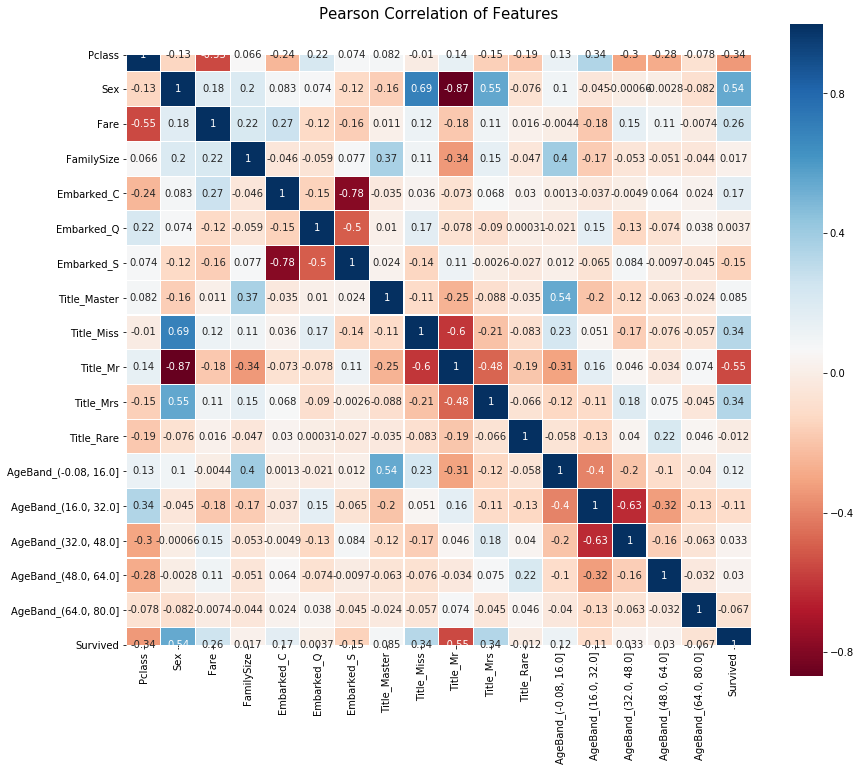

In [94]:
og_train['Survived'] = y_og_train['Survived']
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(og_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [95]:
# Some useful parameters which will come in handy later on
ntrain = og_train.shape[0]
ntest = og_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, shuffle = True, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [96]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [97]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters - replace with gaussian
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

### Before we go any further, how about some hyperparameter tuning for our models?

In [98]:
xtrain, xtest, ytrain, ytest = train_test_split(og_train, y_og_train, test_size = 0.3)

In [147]:
#Preparing the dictionaries:

#Random Forest:
# Preparing the lists for the hyperparameter tuning
estimators = [5, 10, 50, 100, 200, 250, 500, 750 ,1000]
crit = ['gini', 'entropy']
mdepth = [ 4, 5, 6, 7, 8, 9, 10]
mssplit = [2, 5, 7, 10]
msleaf = [1, 2, 4, 7]
mfeatures = ['auto', 'sqrt'] # can be int, float or None

# Preparing the dictionary 
rf_parameters = {
              'n_estimators': estimators, 
              'criterion': crit, 
              'min_samples_split': mssplit, 
              'max_features': mfeatures, 
              'max_depth': mdepth,
              'min_samples_leaf': msleaf,
              'random_state': [0]
             }

# Gaussian Process Classifier
nroptimizer = [0, 1, 2, 5, 10] #n_restarts_optimizer
miter_pred = [50, 100, 150, 200] #max_iter_predict
gpc_parameters = {
              'n_restarts_optimizer': nroptimizer,
              'max_iter_predict': miter_pred,
              'random_state': [0]
            }

# AdaBoost parameters
ada_nestimators = [25, 50, 75, 100, 150, 200, 500]
l_rate = [0.5, 0.75, 1, 1.25, 1.5, 2.0]

ada_parameters = {
    'n_estimators': ada_nestimators,
    'learning_rate' : l_rate,
    'random_state' : [0]
}

#GradientBoosting parameters
gb_nestimators = [50, 100, 150, 250, 500, 750]
gb_mssplit = [2, 5, 7, 10]
gb_msleaf = [1, 2, 3, 4]
gb_mdepth = [2, 3, 4, 5, 7, 10]
gb_parameters = {
    'n_estimators': gb_nestimators,
     #'max_features': 0.2,
    'max_depth': gb_mdepth,
    'min_samples_leaf': gb_msleaf,
    'min_samples_split': gb_mssplit,
    'max_depth': gb_mdepth,
    'random_state': [0]
}

# Support Vector Classifier parameters
svc_C = [0.1, 0.25, 0.5, 0.75, 1.0]
svc_kernel = ['linear']
#svc_brties = [False, True]
svc_parameters = {
    'kernel' : svc_kernel,
    'C' : svc_C,
    #'break_ties': svc_brties,
    'random_state': [0]
    }


In [142]:
rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
score = make_scorer(accuracy_score, greater_is_better = True)
gsc = GridSearchCV(estimator = rf, cv = skf, param_grid = rf_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
rf_best_parameters = gsc.best_params_     

In [145]:
gp = GaussianProcessClassifier()
gsc = GridSearchCV(estimator = gp, cv = skf, param_grid = gpc_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
gp_best_parameters = gsc.best_params_
print('Gaussian Process Classifier Done')

ada = AdaBoostClassifier()
gsc = GridSearchCV(estimator = ada, cv = skf, param_grid = ada_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
ada_best_parameters = gsc.best_params_
print('AdaBoost Classifier Done')

Gaussian Process Classifier Done
AdaBoost Classifier Done


NameError: name 'GradientBoostClassifier' is not defined

In [148]:
gb = GradientBoostingClassifier()
gsc = GridSearchCV(estimator = gb, cv = skf, param_grid = gb_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
gb_best_parameters = gsc.best_params_
print('Gradient Boost Classifier Done')

Gradient Boost Classifier Done


In [149]:
svc = SVC()
gsc = GridSearchCV(estimator = svc, cv = skf, param_grid = svc_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(og_train, y_og_train)
svc_best_parameters = gsc.best_params_
print('SVC Boost Classifier Done')

SVC Boost Classifier Done


In [151]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_best_parameters)
gp = SklearnHelper(clf = GaussianProcessClassifier, seed = SEED, params = gp_best_parameters)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_best_parameters)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_best_parameters)
svc = SklearnHelper(clf = SVC, seed = SEED, params = svc_best_parameters)

In [153]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = y_og_train['Survived'].ravel()
#train = og_train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = og_test.values # Creats an array of the test data

In [154]:
# Create our OOF train and test predictions. These base results will be used as new features
gp_oof_train, gp_oof_test = get_oof(gp, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [156]:
rf_feature = rf.feature_importances(x_train,y_train)
#gp_feature = gp.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11828832 0.21471002 0.15350193 0.08653948 0.01430743 0.00633814
 0.01463612 0.01398089 0.05417463 0.21793329 0.05693625 0.00805559
 0.01548582 0.01036057 0.00871649 0.00536006 0.00067496]
[0.018 0.014 0.858 0.032 0.012 0.    0.006 0.016 0.    0.002 0.012 0.006
 0.006 0.    0.004 0.008 0.006]
[0.13211061 0.25058127 0.17680708 0.10097217 0.00154268 0.00257881
 0.0064876  0.03808519 0.00147099 0.25623339 0.00143438 0.01311828
 0.00254559 0.00109491 0.00399533 0.00752944 0.00341227]


In [169]:
rf_features = [0.11828832, 0.21471002, 0.15350193, 0.08653948, 0.01430743, 0.00633814,
 0.01463612, 0.01398089, 0.05417463, 0.21793329, 0.05693625, 0.00805559,
 0.01548582, 0.01036057, 0.00871649, 0.00536006, 0.00067496]
#et_features = [0.15115045, 0.24452459, 0.04866342, 0.06060435, 0.02030596, 0.01073089,
# 0.01759968, 0.02077694, 0.06596714, 0.23577189, 0.0695893,  0.0110977,
# 0.01533318, 0.00901768, 0.00996159, 0.00720648, 0.00169877]
ada_features = [0.018, 0.014, 0.858, 0.032, 0.012, 0., 0.006, 0.016, 0., 0.002, 0.012, 0.006,
 0.006, 0., 0.004, 0.008, 0.006]
gb_features = [0.13211061, 0.25058127, 0.17680708, 0.10097217, 0.00154268, 0.00257881,
 0.0064876,  0.03808519, 0.00147099, 0.25623339, 0.00143438, 0.01311828,
 0.00254559, 0.00109491, 0.00399533, 0.00752944, 0.00341227]

In [170]:
#del(og_train['Survived'])
cols = og_train.columns.values
# Create a dataframe with features
feature_dataframe = ({'features': cols,
     'Random Forest feature importances': rf_features,
     #'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features})

feature_dataframe = pd.DataFrame(feature_dataframe)

In [171]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,

        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,

        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,

        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

KeyError: 'Extra Trees  feature importances'

In [172]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)


,features,Random Forest feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.118288,0.018,0.132111,0.089466
1,Sex,0.214710,0.014,0.250581,0.159764
2,Fare,0.153502,0.858,0.176807,0.396103


In [173]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')


In [174]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [175]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')



In [176]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [177]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)


In [181]:
gp = GaussianProcessClassifier()
gsc = GridSearchCV(estimator = gp, cv = skf, param_grid = gpc_parameters, scoring = score, verbose = 0, n_jobs = -1)
gsc.fit(x_train, y_train)
predictions = gsc.best_estimator_.predict(x_test)

In [182]:
submit(predictions)

### Here, we are going to delete 'Age'.